In [1]:
import torch
import discretize_distributions as dd
from discretize_distributions.utils import calculate_w2_disc_uni_stand_normal
from discretize_distributions.discretize import GRID_CONFIGS, OPTIMAL_1D_GRIDS
from discretize_distributions.grid import Grid
from matplotlib import pyplot as plt, patches
from scipy.spatial import Voronoi, voronoi_plot_2d
from discretize_distributions.distributions import DiscretizedMixtureMultivariateNormal, \
    DiscretizedMixtureMultivariateNormalQuantization
import GMMWas
import numpy as np

/Users/elizealwash/PycharmProjects/MSc_Thesis_code/.venv/lib/python3.9/site-packages/ot/lp/cvx.py:17: UserWarning: The module ot.lp.cvx is deprecated and will be removed in future versions.The function `barycenter` was moved to ot.lp._barycenter_solvers and canbe importer via ot.lp.
  warnings.warn(


Quantization using grid on whole GMM vs Union of W2-optimal Gaussian signatures - 2D example

In [2]:
# settings for GMM
num_dims = 2
num_mix_elems0 = 2
batch_size = torch.Size()
torch.manual_seed(0)
probs = torch.tensor([0.3, 0.7])

Spread out example

In [3]:
locs = torch.tensor([[0.0, 0.0], [1.5, 1.5]])
# ONLY DIAGONAL COV
covariance_matrix = torch.tensor([[[0.5, 0.0000],
                                   [0.0000, 0.5]],
                                  [[0.2, 0.0000],
                                   [0.0000, 0.2]]])

Overlap example

In [4]:
locs = torch.tensor([[1.0, 1.0], [1.3, 1.3]])
covariance_matrix = torch.tensor([[[0.3, 0.0000],
                                   [0.0000, 0.3]],
                                  [[0.5, 0.0000],
                                   [0.0000, 0.5]]])

In [5]:
gmm = dd.MixtureMultivariateNormal(
        mixture_distribution=torch.distributions.Categorical(probs=probs),
        component_distribution=dd.MultivariateNormal(
            loc=locs,
            covariance_matrix=covariance_matrix*(1 / (np.sqrt(num_dims)))  # scaling
        )
    )

/Users/elizealwash/PycharmProjects/MSc_Thesis_code/.venv/lib/python3.9/site-packages/torch/distributions/distribution.py:56: UserWarning: <class 'discretize_distributions.distributions.multivariate_normal.MultivariateNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


W2-optimal grids per Gaussian

In [6]:
# original method using signature operator
disc_gmm = dd.discretization_generator(gmm, num_locs=100)
locs_gmm = disc_gmm.locs
probs_gmm = disc_gmm.probs.detach().numpy()
print(f'W2 error original Signature operation: {disc_gmm.w2}')
print(f'Number of signature locations: {len(locs_gmm)}')

Signature w2: 0.1130 / 0.7461 for grid of size: 100
W2 error original Signature operation: 0.11946927011013031
Number of signature locations: 200


Grid1: Union of locations

In [7]:
grid_list = [torch.sort(torch.unique(locs_gmm[:, i]))[0] for i in range(locs_gmm.shape[1])]
grid_union = Grid(locs_per_dim=grid_list)

Grid2: Average W2-optimal Gaussian signature

In [8]:
mean = (gmm.component_distribution.mean[0] + gmm.component_distribution.mean[1]) / 2
var = (gmm.component_distribution.variance[0] + gmm.component_distribution.variance[1]) / 2
avg_cov = torch.diag_embed(var)
avg_dist = dd.MultivariateNormal(loc=mean, covariance_matrix=avg_cov)
disc_avg_dist = dd.discretization_generator(avg_dist, num_locs=100)
locs_avg = disc_avg_dist.locs.squeeze(0)  # (1,locs,dims) --> (locs,dims)
grid_list = [torch.sort(torch.unique(locs_avg[:, i]))[0] for i in range(locs_avg.shape[1])]
grid_avg = Grid(locs_per_dim=grid_list)

Signature w2: 0.1139 / 0.7521 for grid of size: 100


Quantization using grid on whole GMM, where the W₂ error is calculated according to:

$$
W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P},\mathbb{P}) \leq \sum^M_{i=1} \bar{\pi}_i W_2^2(\Delta_{\mathcal{C,R}}\#\mathbb{P}_i, \mathbb{P}_i)
$$


In [9]:
# set grid
grid = grid_avg
q = DiscretizedMixtureMultivariateNormalQuantization(gmm, grid=grid)
w2 = q.w2
probs_grid = q.probs.detach().numpy()
locs_grid = q.locs.detach().numpy()
print(f'W2 error for Quantization: {w2.item()}')
print(f'Number of locations: {len(locs_grid)}')

W2 error for Quantization: 0.23088844120502472
Number of locations: 100


Plotting

In [10]:
# scaling to compare prob mass across grid and signature
s_gmm = (probs_gmm - probs_gmm.min()) / (probs_gmm.max() - probs_gmm.min()) * 100
s_grid = (probs_grid - probs_grid.min()) / (probs_grid.max() - probs_grid.min()) * 100

global_min = min(probs_grid.min(), probs_gmm.min())
global_max = max(probs_grid.max(), probs_gmm.max())

s_grid2 = (probs_grid - global_min) / (global_max - global_min) * 100
s_gmm2 = (probs_gmm - global_min) / (global_max - global_min) * 100

x_min, x_max = locs_gmm[:, 0].min().item(), locs_gmm[:, 0].max().item()
y_min, y_max = locs_gmm[:, 1].min().item(), locs_gmm[:, 1].max().item()

padding = 0.1
x_range = x_max - x_min
y_range = y_max - y_min
x_min -= x_range * padding
x_max += x_range * padding
y_min -= y_range * padding
y_max += y_range * padding

x_grid_min, x_grid_max = locs_grid[:, 0].min(), locs_grid[:, 0].max()
y_grid_min, y_grid_max = locs_grid[:, 1].min(), locs_grid[:, 1].max()
width = x_grid_max - x_grid_min
height = y_grid_max - y_grid_min

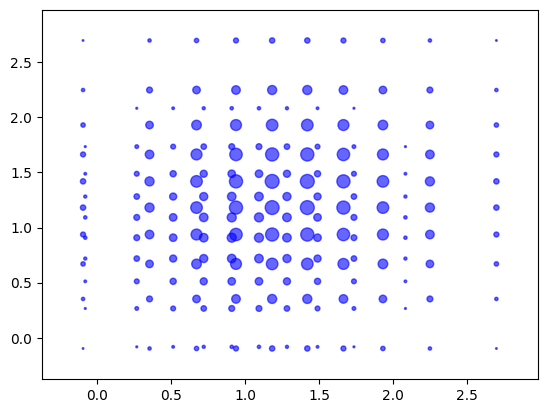

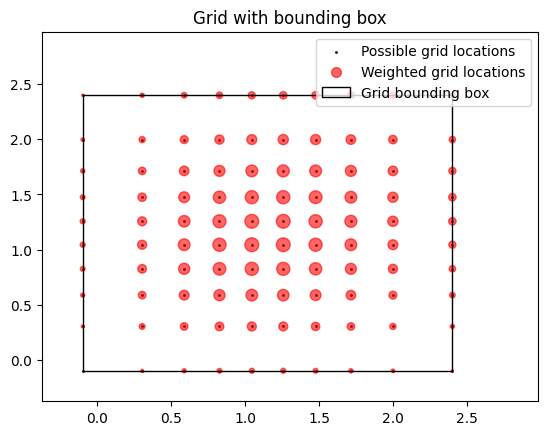

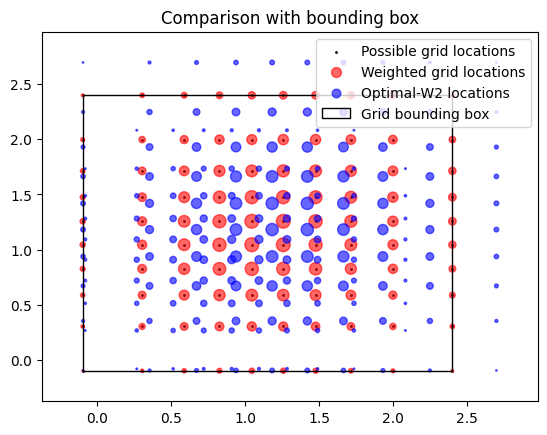

In [11]:
# Plot 1
plt.figure()
plt.scatter(locs_gmm[:, 0], locs_gmm[:, 1], s=s_gmm, label="Locations", color='blue', alpha=0.6)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

# Plot 2
plt.figure()
plt.scatter(locs_grid[:, 0], locs_grid[:, 1], s=1, label="Possible grid locations", color='black')
plt.scatter(locs_grid[:, 0], locs_grid[:, 1], s=s_grid, label="Weighted grid locations", color='red', alpha=0.6)
rect = patches.Rectangle((x_grid_min, y_grid_min), width, height, linewidth=1, edgecolor='black',
                         facecolor='none', label='Grid bounding box')
plt.gca().add_patch(rect)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.legend()
plt.title("Grid with bounding box")
plt.show()

# Plot 3
plt.figure()
plt.scatter(locs_grid[:, 0], locs_grid[:, 1], s=1, label="Possible grid locations", color='black')
plt.scatter(locs_grid[:, 0], locs_grid[:, 1], s=s_grid2, label="Weighted grid locations", color='red', alpha=0.6)
plt.scatter(locs_gmm[:, 0], locs_gmm[:, 1], s=s_gmm2, label="Optimal-W2 locations", color='blue', alpha=0.6)
rect = patches.Rectangle((x_grid_min, y_grid_min), width, height, linewidth=1, edgecolor='black',
                         facecolor='none', label='Grid bounding box')
plt.gca().add_patch(rect)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.legend()
plt.title("Comparison with bounding box")
plt.show()